<a href="https://colab.research.google.com/github/haroon9213/CNN_classfication_workshops/blob/main/Notebooks/%3CCaltech_dataset%3E%3CDensenet201%3E%3CHaroon%3E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfd
from tensorflow.keras.applications import DenseNet201,DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import layers

2025-09-13 01:15:12.976865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757726113.167773      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757726113.217989      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS_HEAD = 20
EPOCHS_FINE = 20
NUM_CLASSES = 102  # Caltech101 has 101 classes + background

In [ ]:
EPOCHS_HEAD = 20
NUM_CLASSES = 102  # Caltech101 has 101 classes + background
model.compile(
    optimizer=Adam(learning_rate=(1e-3),amsgrad=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
# Callbacks
callbacks = [
  # tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint( filepath='best_model.weights.h5',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1,mode='min'),
]

In [ ]:
(ds_train,ds_test), info = tfd.load('caltech101',split=['train', 'test'],with_info=True,as_supervised=True)
total_train = ds_train.cardinality().numpy()
val_size = int(0.2 * total_train)
ds_val = ds_train.take(val_size)
ds_train = ds_train.skip(val_size)

In [ ]:


# Preprocessin
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.one_hot(label, NUM_CLASSES)  # categorical_crossentropy needs one-hot

train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [ ]:

# Build model
base_model = DenseNet201(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # phase 1: frozen

model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(512, activation=layers.LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation="softmax"),
])

model.compile(
    optimizer=Adam(learning_rate=(1e-3),amsgrad=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 9, 9, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:

# Callbacks
callbacks = [
  # tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint( filepath='best_model.weights.h5',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True,verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1,mode='min'),
]

In [ ]:

print("\n==== Phase 1: Training classifier head ====")
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
)
# print("\nEvaluating Phase 1 model on test set…")
# test_loss1, test_acc1 = model.evaluate(test_ds)
# print(f"Phase 1 (Head Only) Test Accuracy: {test_acc1:.4f}")

# Print val_accuracy for Phase 1
# -------------------------------
# print("\n📊 Phase 1 Validation Accuracy per Epoch:")
# for i, acc in enumerate(history1.history["val_accuracy"]):
#     print(f"Epoch {i+1} : {acc:.4f}")

# # Phase 2: Fine-tune
# print("\n==== Phase 2: Fine-tuning last 40 layers ====")
# base_model.trainable = True
# for layer in base_model.layers[:-40]:
#     layer.trainable = False

# model.compile(
#     optimizer=Adam(learning_rate=1e-4),  # lower LR for fine-tuning
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )

# history2 = model.fit(a
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS_FINE,
#     callbacks=callbacks,
# )
# ✅ Evaluate after Phase 2
# print("\nEvaluating Phase 2 model on test set…")
# test_loss2, test_acc2 = model.evaluate(test_ds)
# print(f"Phase 2 (Fine-tuned) Test Accuracy: {test_acc2:.4f}")

# print(f"Phase 1 Test Accuracy : {test_acc1:.4f}")
# print(f"Phase 2 Test Accuracy : {test_acc2:.4f}")


# print("\nEvaluating on test set…")
# test_loss, test_acc = model.evaluate(test_ds)
# print(f"Test accuracy: {test_acc:.4f}")




==== Phase 1: Training classifier head ====
Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.3010 - loss: 3.4685
Epoch 1: val_accuracy improved from -inf to 0.72831, saving model to best_model.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 97s 703ms/step - accuracy: 0.3035 - loss: 3.4529 - val_accuracy: 0.7283 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8341 - loss: 0.6125
Epoch 2: val_accuracy improved from 0.72831 to 0.84452, saving model to best_model.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 45s 574ms/step - accuracy: 0.8342 - loss: 0.6122 - val_accuracy: 0.8445 - val_loss: 0.5707 - learning_rate: 0.0010
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9158 - loss: 0.3251
Epoch 3: val_accuracy improved from 0.84452 to 0.88380, saving model to best_model.weights.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 44s 567ms/step - accuracy: 0.9159 - loss: 0.3249 - val_accuracy: 0.8838 - val_loss: 0.4630 - learning_rate:

In [ ]:
print(", ".join([f"Epoch {i+1} : {acc:.4f}" for i, acc in enumerate(history1.history["val_accuracy"])]))
print("\nEvaluating Phase 1 model on test set…")
test_loss1, test_acc1 = model.evaluate(test_ds)
print(f"Phase 1 (Head Only) Test Accuracy: {test_acc1:.4f}")

Epoch 1 : 0.7283, Epoch 2 : 0.8445, Epoch 3 : 0.8838, Epoch 4 : 0.8805, Epoch 5 : 0.8920, Epoch 6 : 0.9083, Epoch 7 : 0.8887, Epoch 8 : 0.9051, Epoch 9 : 0.9149, Epoch 10 : 0.9133, Epoch 11 : 0.9182, Epoch 12 : 0.9214, Epoch 13 : 0.9182, Epoch 14 : 0.9182, Epoch 15 : 0.9116, Epoch 16 : 0.9182, Epoch 17 : 0.9182, Epoch 18 : 0.9198, Epoch 19 : 0.9231, Epoch 20 : 0.9214

Evaluating Phase 1 model on test set…
191/191 ━━━━━━━━━━━━━━━━━━━━ 75s 392ms/step - accuracy: 0.9202 - loss: 0.3882
Phase 1 (Head Only) Test Accuracy: 0.9172


In [ ]:
# import matplotlib.pyplot as plt

# # Example data (replace with your actual validation accuracy histories)
# epochs = list(range(1, 20))
# val_acc_32  = [0.799,0.827,0.833,0.828,0.845,0.833,0.834,0.838,0.870,0.867,0.867,0.868,0.873,0.875,0.876,0.878,0.879,0.880,0.882]
# val_acc_64  = [0.801,0.839,0.837,0.840,0.845,0.840,0.841,0.842,0.868,0.869,0.870,0.871,0.872,0.873,0.874,0.875,0.876,0.877,0.878]
# val_acc_128 = [0.802,0.841,0.846,0.847,0.851,0.849,0.850,0.852,0.874,0.875,0.876,0.877,0.878,0.879,0.880,0.881,0.882,0.883,0.884]
# val_acc_256 = [0.789,0.832,0.846,0.852,0.857,0.862,0.860,0.861,0.872,0.873,0.875,0.876,0.878,0.879,0.880,0.881,0.883,0.884,0.885]
# val_acc_512 = [0.788,0.854,0.856,0.861,0.860,0.859,0.860,0.861,0.863,0.865,0.866,0.867,0.868,0.869,0.870,0.871,0.872,0.873,0.874]

# # Plot
# plt.figure(figsize=(12,6))
# plt.plot(epochs, val_acc_32,  marker='o', label='Batch Size 32')
# plt.plot(epochs, val_acc_64,  marker='o', label='Batch Size 64')
# plt.plot(epochs, val_acc_128, marker='o', label='Batch Size 128')
# plt.plot(epochs, val_acc_256, marker='o', label='Batch Size 256')
# plt.plot(epochs, val_acc_512, marker='o', label='Batch Size 512')

# plt.xlabel("Epochs")
# plt.ylabel("Validation Accuracy")
# plt.title("Validation Accuracy vs Epochs for Different Batch Sizes")
# plt.legend(title="Batch Sizes")
# plt.grid(True)
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # ----- Phase 1 -----
# plt.figure(figsize=(8,5))
# plt.plot(history1.history['accuracy'], label='Training Accuracy')
# plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Phase 1: Training only the classifier head\n(Base model frozen)')
# plt.legend()
# plt.grid()
# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(history1.history['loss'], label='Training Loss')
# plt.plot(history1.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Phase 1: Loss curves\n(Base model frozen)')
# plt.legend()
# plt.grid()
# plt.show()


# # ----- Phase 2 -----
# plt.figure(figsize=(8,5))
# plt.plot(history2.history['accuracy'], label='Training Accuracy')
# plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Phase 2: Fine-tuning last layers of DenseNet201\n(Base model partially unfrozen)')
# plt.legend()
# plt.grid()
# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(history2.history['loss'], label='Training Loss')
# plt.plot(history2.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Phase 2: Loss curves\n(Base model partially unfrozen)')
# plt.legend()
# plt.grid()
# plt.show()


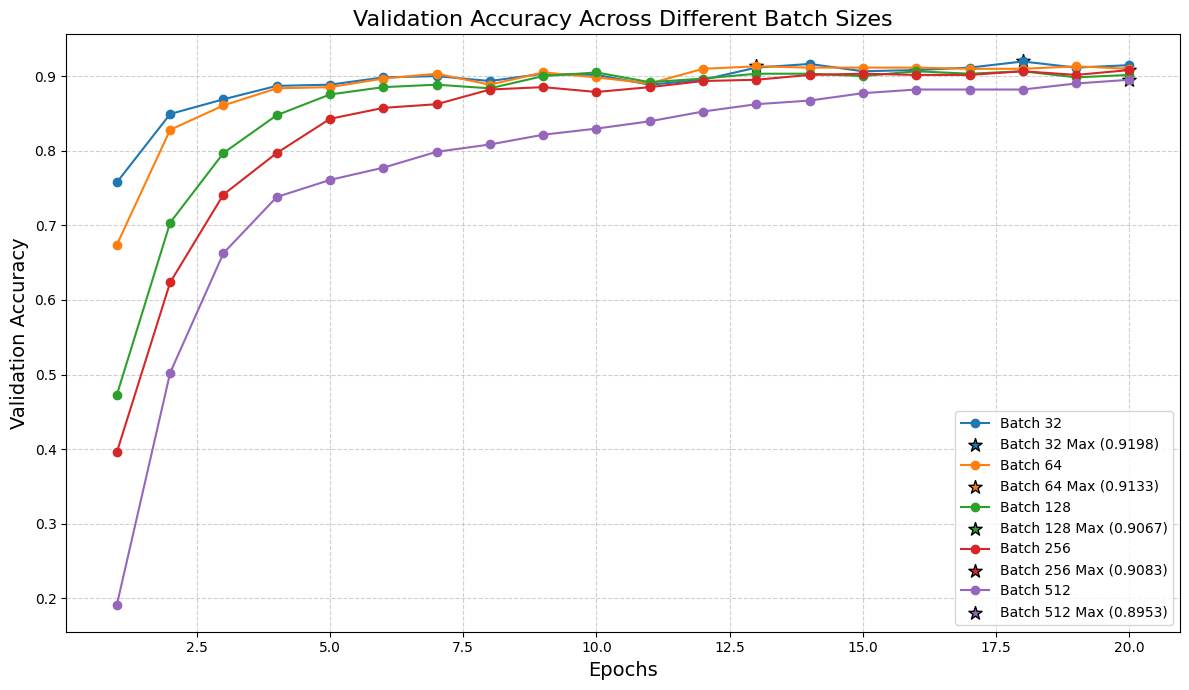

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each batch size (val_accuracy per epoch)
batch_32 = [0.7578,0.8494,0.8691,0.8871,0.8887,0.8985,0.9002,0.8936,0.9034,0.9018,
            0.8887,0.8953,0.9116,0.9165,0.9067,0.9083,0.9116,0.9198,0.9116,0.9149]

batch_64 = [0.6743,0.8282,0.8609,0.8838,0.8854,0.8969,0.9034,0.8887,0.9051,0.8985,
            0.8903,0.9100,0.9133,0.9116,0.9116,0.9116,0.9100,0.9100,0.9133,0.9100]

batch_128 = [0.4730,0.7038,0.7971,0.8478,0.8756,0.8854,0.8887,0.8838,0.9002,0.9051,
             0.8920,0.8969,0.9034,0.9034,0.9002,0.9067,0.9034,0.9067,0.8985,0.9018]

batch_256 = [0.3961,0.6236,0.7414,0.7971,0.8429,0.8576,0.8625,0.8822,0.8854,0.8789,
             0.8854,0.8936,0.8953,0.9018,0.9034,0.9018,0.9018,0.9067,0.9018,0.9083]

batch_512 = [0.1915,0.5025,0.6628,0.7381,0.7610,0.7774,0.7987,0.8085,0.8216,0.8298,
             0.8396,0.8527,0.8625,0.8674,0.8773,0.8822,0.8822,0.8822,0.8903,0.8953]

# X-axis (epochs)
epochs = np.arange(1, 21)

# Dictionary for looping
batch_dict = {
    "Batch 32": batch_32,
    "Batch 64": batch_64,
    "Batch 128": batch_128,
    "Batch 256": batch_256,
    "Batch 512": batch_512
}

plt.figure(figsize=(12,7))

# Plot each batch size
for label, acc in batch_dict.items():
    plt.plot(epochs, acc, marker='o', label=label)

    # Highlight max accuracy
    max_epoch = np.argmax(acc) + 1
    max_acc = max(acc)
    plt.scatter(max_epoch, max_acc, s=100, marker='*', edgecolors='black', label=f"{label} Max ({max_acc:.4f})")

# Graph details
plt.title("Validation Accuracy Across Different Batch Sizes", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Validation Accuracy", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()




